In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv("..\..\Assignments\Assignment1\Train_rev1.csv")
train[:3]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


In [44]:
train_sample = train.sample(10000).reset_index() # Creates sample of 1000 job descriptions

# Part A (Basic Text Mining)

In [5]:
# Tokenize all job descriptions
train_sample['tokenized_strip'] = train_sample.apply(lambda row: row['FullDescription'].decode('utf-8').strip(),axis=1)
train_sample['tokenized'] = train_sample.apply(lambda row: nltk.word_tokenize(row['tokenized_strip']),axis=1)

In [6]:
# Get part of speech tags for each token in each description
train_sample['PoS'] = train_sample.apply(lambda row: nltk.pos_tag(row['tokenized']), axis=1)

## A1. Top 5 Parts of Speech in Corpus

In [7]:
# Create list of all tokens in corpus
all_tokens = []
for i in range(len(train_sample['tokenized'])):
    all_tokens = all_tokens + train_sample['tokenized'][i]

In [8]:
# Get part of speech tags for all tokens in corpus
all_PoS = nltk.pos_tag(all_tokens)

In [9]:
tokens, PoS = zip(*all_PoS) # Unzip all_PoS to separate list of tokens from list of parts of speech
PoS_freq = nltk.FreqDist(PoS) # Frequency of each part of speech
top5_PoS = PoS_freq.most_common()[:5] # 5 most frequent parts of speech in corpus
top5_PoS

[('NN', 45695), ('NNP', 35081), ('IN', 26039), ('JJ', 21797), ('DT', 20048)]

The 5 most common parts of speech in this corpus along with their respective frequencies are:
1. Noun, singular or mass: 46,389
2. Proper noun, singular: 33,742
3. Preposition or Subordinating Conjunction: 25,724
4. Adjective: 22,063
5. Determiner: 20,188

## A2. Zipf's Law, 100 Most Common Words

In [10]:
from nltk.tokenize import RegexpTokenizer
word_tokenizer = RegexpTokenizer(r'\w+')

# Get list of words without punctuation for each job description
train_sample['tokenized_words'] = train_sample.apply(lambda row: word_tokenizer.tokenize(row['tokenized_strip']),axis=1)

# Create list of words from all job descriptions
all_words = []
for i in range(len(train_sample['tokenized_words'])):
    all_words = all_words + train_sample['tokenized_words'][i]

# Make all words lowercase
words_lower = []
for word in all_words:
    words_lower.append(word.lower())

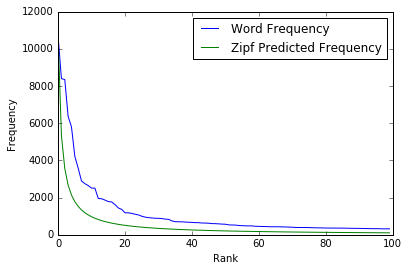

In [11]:
# Find 100 most frequent words
words_freq = nltk.FreqDist(words_lower)
top100_words = words_freq.most_common()[:100]

# Get values for expected frequency of top 100 words using Zipf's Law
max_freq = top100_words[0][1]
counter = 1
zipf = []
while len(zipf) < 100:
    zipf.append(max_freq/counter)
    counter += 1

# Plot actual frequencies and Zipf frequencies
plot([b for (a,b) in top100_words], label = 'Word Frequency') # Blue
plot(zipf, label = 'Zipf Predicted Frequency') # Green
legend(loc='best')
xlabel('Rank')
ylabel('Frequency')

## Top 10 Words after Stemming and Removing Stop Words

In [12]:
# Remove stop words
from nltk.corpus import stopwords
no_stops_words = [word for word in words_lower if word not in stopwords.words('english')]

In [13]:
from nltk.stem.porter import PorterStemmer
PS = PorterStemmer()

# Perform stemming on words
stem_words = []
for word in no_stops_words:
    stem_word = PS.stem(word)
    stem_words.append(stem_word)

In [14]:
# Find 10 most frequent words
words_freq_no_stops = nltk.FreqDist(stem_words)
top10_words = words_freq_no_stops.most_common()[:10]

top10_words

[(u'work', 2234),
 (u'manag', 1887),
 (u'experi', 1806),
 (u'develop', 1562),
 (u'client', 1276),
 (u'role', 1241),
 (u'team', 1237),
 (u'busi', 1179),
 (u'requir', 1122),
 (u'skill', 1064)]

Due to the size of the data set, we chose to use stemming rather than lemmatization. This resulted in a list of the top 10 word stems rather than words themselves or lemmas. However, given the context, the lemmas for each stem can be estimated. 

The 10 most frequent word stems with their likely associated lemmas are listed below, along with their respective frequencies:
1. 'work' (work) - 2141
2. 'manag' (manage) - 2049
3. 'experi'(experience) - 1642
4. 'role' (role) - 1246
5. 'team' (team) - 1226
6. 'busi' (business) - 1213
7. 'client' (client) - 1206
8. 'develop' (develop) - 1150
9. 'requir' (require) - 1018
10. 'servic' (service) - 1017

# Part B (Salary Prediction)

In [45]:
#Create new classifier for job posting salaries in the top quartile
sal_75 = train_sample['SalaryNormalized'].quantile(.75)

train_sample['salary_class'] = np.where(train_sample['SalaryNormalized']>=sal_75,'high','low')

train_sample.head()

,index,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,salary_class
0,114736,69754259,Countryside Information and Membership Officer...,About the role “Wow” “Stunning” “A little heav...,Brighton,Brighton,part_time,NaN,National Trust,Customer Services Jobs,7.30 - 7.30 per hour,14016,Jobcentre Plus,low
1,56307,68682172,Immediate Start: Media & Entertainment Sales R...,Immediate Start: Media Entertainment Sales Rep...,Glasgow Lanarkshire Scotland,UK,NaN,permanent,PAP Worldwide,Engineering Jobs,Approximately 350+ per week (based on results),16800,totaljobs.com,low
2,159619,71173685,Mechanical Design Engineer,Mechanical Design Engineer required with exper...,Hertfordshire South East,UK,NaN,contract,Modis,Engineering Jobs,30 - 32 per hour,59520,totaljobs.com,high
3,225914,72440355,Quality Conformance Engineer **** Pension H...,Quality Conformance Engineer **** Pension H...,Guildford Surrey South East,Guildford,NaN,permanent,Mulberry Recruitment,Engineering Jobs,"From 27,000 to 27,000 per annum + OTE",27000,totaljobs.com,low
4,232456,72478816,"Childrens Services MI, Data Support & ICT Trai...","Childrens Services MI, Data Support & ICT Trai...",Poole,Poole,full_time,NaN,Borough of Poole,Other/General Jobs,21519,21519,careerbuilder.com,low


In [46]:
#Create two separate lists for text and salary classifier for each job posting
descriptions = []
pay_class = []

for index, value in train_sample.iterrows():
    descriptions.append(value['FullDescription'])
    pay_class.append(value['salary_class'])

In [47]:
#Split data into test/training set
trainset_size = int(round(len(train_sample)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay_class[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay_class[trainset_size+1:len(pay_class)]]) 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Create TF IDF Matrix
vectorizer = TfidfVectorizer(min_df=2, 
 ngram_range=(1, 2), 
 stop_words='english', 
 strip_accents='unicode', 
 norm='l2')

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [49]:
from sklearn.naive_bayes import MultinomialNB

#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [28]:
y_nb_predicted

array(['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low',
       'low', 'low',

In [50]:
from sklearn import metrics
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'micro', pos_label=None))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'micro', pos_label=None))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.743897559024
Recall: 0.743897559024
Accuracy: 0.743897559024


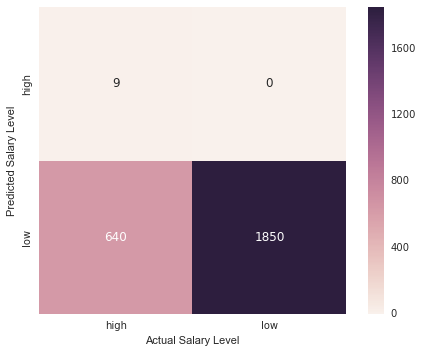

In [63]:
#Fancy boy confusion matrix
import seaborn as sns; sns.set()

mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay_class), yticklabels=unique(pay_class))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');

In [55]:
?sns.heatmap